In [1]:
!nvidia-smi

Mon Apr 23 23:59:31 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
| 29%   53C    P2    65W / 200W |   1299MiB /  8118MiB |     73%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

hidden_layer = [10, 8, 4, 2]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l1(10e-5))(encoder1)
encoder3 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l1(10e-5))(encoder2)
latent = Dense(hidden_layer[3], activation="relu", activity_regularizer=regularizers.l1(10e-5))(encoder3)
decoder1 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l1(10e-5))(latent)
decoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l1(10e-5))(decoder1)
decoder3 = Dense(input_shape, activation="relu", activity_regularizer=regularizers.l1(10e-5))(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
__________

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE4.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 33s 8us/step - loss: 2505320429483.0942 - acc: 0.3929 - val_loss: 890393460848.9797 - val_acc: 0.5245
Epoch 2/200
4072076/4072076 [==============================] - 33s 8us/step - loss: 869410075012.0063 - acc: 0.5415 - val_loss: 865403241203.1299 - val_acc: 0.5686
Epoch 3/200
4072076/4072076 [==============================] - 33s 8us/step - loss: 855894278718.8938 - acc: 0.5644 - val_loss: 864738552211.5969 - val_acc: 0.5656
Epoch 4/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 855648047884.2252 - acc: 0.5621 - val_loss: 864611817234.8148 - val_acc: 0.5646
Epoch 5/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 855648330072.2427 - acc: 0.5610 - val_loss: 864858003176.4877 - val_acc: 0.5612
Epoch 6/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 855582119325.9226 - acc: 0.5612 - val_los

4072076/4072076 [==============================] - 32s 8us/step - loss: 824618839954.0579 - acc: 0.7192 - val_loss: 832739021862.2031 - val_acc: 0.7198
Epoch 51/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 824655894417.7219 - acc: 0.7160 - val_loss: 832712033884.4700 - val_acc: 0.7265
Epoch 52/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 824503246580.4935 - acc: 0.7150 - val_loss: 832747053162.8640 - val_acc: 0.7226
Epoch 53/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 824405427719.3102 - acc: 0.7143 - val_loss: 832393448599.4645 - val_acc: 0.7233
Epoch 54/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 824081545826.5481 - acc: 0.7118 - val_loss: 832299418976.6796 - val_acc: 0.7156
Epoch 55/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 824003161573.8407 - acc: 0.7167 - val_loss: 831982878886.4923 - val_acc: 0.7148
Epoch 56/200
4072076/40

4072076/4072076 [==============================] - 32s 8us/step - loss: 4319422417.3540 - acc: 0.7968 - val_loss: 4322762976.6218 - val_acc: 0.8221
Epoch 101/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 4339968469.0950 - acc: 0.8010 - val_loss: 3631126799.7017 - val_acc: 0.8101
Epoch 102/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 4475079014.1102 - acc: 0.7976 - val_loss: 3481940180.7474 - val_acc: 0.8416
Epoch 103/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 4307656504.4779 - acc: 0.8048 - val_loss: 3866275346.1259 - val_acc: 0.8366
Epoch 104/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 4354115287.9272 - acc: 0.7948 - val_loss: 3712582363.2655 - val_acc: 0.8466
Epoch 105/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 4342621022.6166 - acc: 0.8048 - val_loss: 3718892861.7657 - val_acc: 0.8148
Epoch 106/200
4072076/4072076 [===========

4072076/4072076 [==============================] - 29s 7us/step - loss: 4255649673.9238 - acc: 0.8100 - val_loss: 3492701384.8932 - val_acc: 0.8477
Epoch 151/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 4251735504.2715 - acc: 0.8138 - val_loss: 3434146115.5042 - val_acc: 0.8285
Epoch 152/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 4136885633.7395 - acc: 0.8056 - val_loss: 3429859504.7321 - val_acc: 0.8144
Epoch 153/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 4077210295.6352 - acc: 0.8102 - val_loss: 3180258009.3141 - val_acc: 0.8284
Epoch 154/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 4191553802.3862 - acc: 0.8027 - val_loss: 3341297524.8675 - val_acc: 0.8150
Epoch 155/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 4354365634.8682 - acc: 0.8126 - val_loss: 3140957619.4781 - val_acc: 0.8088
Epoch 156/200
4072076/4072076 [===========

4072076/4072076 [==============================] - 27s 7us/step - loss: 4000302838.9257 - acc: 0.8175 - val_loss: 3102320627.2405 - val_acc: 0.8191


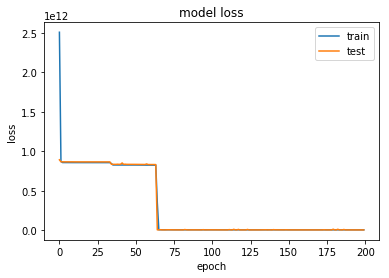

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE4.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [10]:
import numpy as np


predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()
print(predictions.shape)

(1272524, 11)


In [11]:
print(predictions[0][:])
X_test.head(1)

[     0.       7151.7344 186529.     193934.75   291309.72   288420.
      0.          0.          0.          0.          0.    ]


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
3737323,278,330218.42,20866.0,351084.42,452419.57,122201.15,1,0,0,0,0
